In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# SEP532 인공지능 이론과 실제
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### Text classification with an RNN

Let's build text classification model with RNN on the IMDB dataset for sentiment analysis.

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

#### Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using [`TFDS`](https://www.tensorflow.org/datasets).
- Args of [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load):
    - `name`: str, the registered name of the DatasetBuilder.
    - `with_info`: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.
    - `as_supervised`: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2022-05-08 23:32:42.814728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 23:32:43.505597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34845 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:18:00.0, compute capability: 8.0


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2022-05-08 23:32:44.194744: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Next shuffle the data for training and create batches of these (text, label) pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'Wow, this film was just bloody horrid. SO bad in fact that even though I didn\'t pay to see it, I still wanted my money back.<br /><br />The film is about nothing intelligible. It\'s a mish-mash of sci-fi cliche\'s that were done better by much more skilled film makers. The performances, especially by the leads were over the top in a less endearing Ed Wood sort of way. Speaking of Ed Wood, he\'d be proud of the character\'s dialogue. It\'s just too taciturn with no hint of irony or sense of humor. On top of that, it doesn\'t make sense, nor does the plot, or lackthereof.<br /><br />The visual effects are okay, but not enough to go "oh wow, that\'s cool" and they just seem to be thrown in to "be cool" rather than be a good plot device.<br /><br />The soundtrack was another mishmash of stuff that really never set any sort of mood. Again, it seemed as if the director was just throwing in songs in the film in an effort to "be cool".<br /><br />Which brings me to my final point. 

2022-05-08 23:32:44.500926: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Create the text encoder
The raw text loaded by [`tfds`](https://www.tensorflow.org/datasets/api_docs/python/tfds) needs to be processed before it can be used in a model. The simplest way to process text for training is using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer. This layer has many capabilities, but this practice sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt()` method:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt()` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  11,  20, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0],
       [128, 497,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:
1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is "`lower_and_strip_punctuation`".
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [10]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'Wow, this film was just bloody horrid. SO bad in fact that even though I didn\'t pay to see it, I still wanted my money back.<br /><br />The film is about nothing intelligible. It\'s a mish-mash of sci-fi cliche\'s that were done better by much more skilled film makers. The performances, especially by the leads were over the top in a less endearing Ed Wood sort of way. Speaking of Ed Wood, he\'d be proud of the character\'s dialogue. It\'s just too taciturn with no hint of irony or sense of humor. On top of that, it doesn\'t make sense, nor does the plot, or lackthereof.<br /><br />The visual effects are okay, but not enough to go "oh wow, that\'s cool" and they just seem to be thrown in to "be cool" rather than be a good plot device.<br /><br />The soundtrack was another mishmash of stuff that really never set any sort of mood. Again, it seemed as if the director was just throwing in songs in the film in an effort to "be cool".<br /><br />Which brings me to my final point

#### Create the model
![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.
2. The first layer is the `encoder`, which converts the text to a sequence of token indices.
3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors. This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.
4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 
    - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  
    - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.
5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 

The code to implement this is below:

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2022-05-08 23:33:14.424680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-08 23:33:15.154711: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 51s 112ms/step - loss: 0.6291 - accuracy: 0.5804 - val_loss: 0.4686 - val_accuracy: 0.7526
Epoch 2/10


2022-05-08 23:33:59.110892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 107ms/step - loss: 0.4192 - accuracy: 0.8060 - val_loss: 0.3757 - val_accuracy: 0.8344
Epoch 3/10


2022-05-08 23:34:41.022389: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 108ms/step - loss: 0.3578 - accuracy: 0.8468 - val_loss: 0.3533 - val_accuracy: 0.8344
Epoch 4/10


2022-05-08 23:35:23.272645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 107ms/step - loss: 0.3286 - accuracy: 0.8577 - val_loss: 0.3359 - val_accuracy: 0.8484
Epoch 5/10


2022-05-08 23:36:05.409827: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 108ms/step - loss: 0.3164 - accuracy: 0.8645 - val_loss: 0.3327 - val_accuracy: 0.8536
Epoch 6/10


2022-05-08 23:36:47.618428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 107ms/step - loss: 0.3101 - accuracy: 0.8680 - val_loss: 0.3286 - val_accuracy: 0.8568
Epoch 7/10


2022-05-08 23:37:29.757068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 107ms/step - loss: 0.3041 - accuracy: 0.8686 - val_loss: 0.3234 - val_accuracy: 0.8547
Epoch 8/10


2022-05-08 23:38:11.873920: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 108ms/step - loss: 0.2987 - accuracy: 0.8722 - val_loss: 0.3189 - val_accuracy: 0.8521
Epoch 9/10


2022-05-08 23:38:54.038140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 42s 106ms/step - loss: 0.2989 - accuracy: 0.8717 - val_loss: 0.3216 - val_accuracy: 0.8625
Epoch 10/10


2022-05-08 23:39:35.732116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 41s 106ms/step - loss: 0.2969 - accuracy: 0.8733 - val_loss: 0.3226 - val_accuracy: 0.8594


2022-05-08 23:40:17.148871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 53ms/step - loss: 0.3193 - accuracy: 0.8626
Test Loss: 0.3193216025829315
Test Accuracy: 0.8626400232315063


(0.0, 0.6457187205553054)

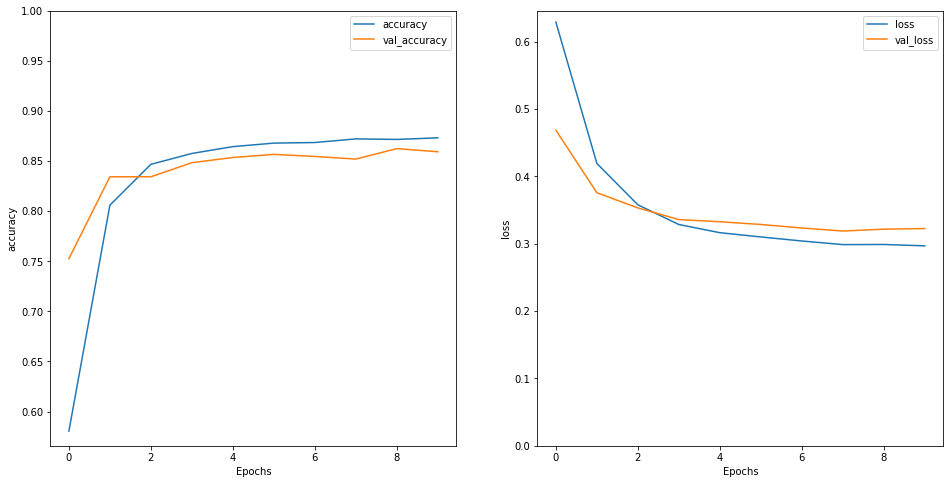

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence: If the prediction is >= `0.0`, it is positive else it is negative.

In [16]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

#### Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.
* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered-bidirectional.png)

The interesting thing about using an RNN with return_sequences=True is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [17]:
model_stacked = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [18]:
model_stacked.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy'])

In [19]:
history = model_stacked.fit(train_dataset, epochs=10,
                            validation_data=test_dataset,
                            validation_steps=30)

Epoch 1/10
391/391 [==============================] - 95s 212ms/step - loss: 0.6283 - accuracy: 0.5935 - val_loss: 0.4512 - val_accuracy: 0.7865
Epoch 2/10
391/391 [==============================] - 79s 202ms/step - loss: 0.4080 - accuracy: 0.8217 - val_loss: 0.3707 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 79s 201ms/step - loss: 0.3474 - accuracy: 0.8550 - val_loss: 0.3339 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 79s 202ms/step - loss: 0.3325 - accuracy: 0.8610 - val_loss: 0.3256 - val_accuracy: 0.8641
Epoch 5/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3172 - accuracy: 0.8678 - val_loss: 0.3217 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3095 - accuracy: 0.8702 - val_loss: 0.3236 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3072 - accuracy: 0.8703 - val_loss: 0.3244 - val_ac

In [20]:
test_loss, test_acc = model_stacked.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 38s 98ms/step - loss: 0.3216 - accuracy: 0.8484
Test Loss: 0.3216036856174469
Test Accuracy: 0.8483999967575073


In [21]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model_stacked.predict(np.array([sample_text]))
print(predictions)

[[-2.1470659]]


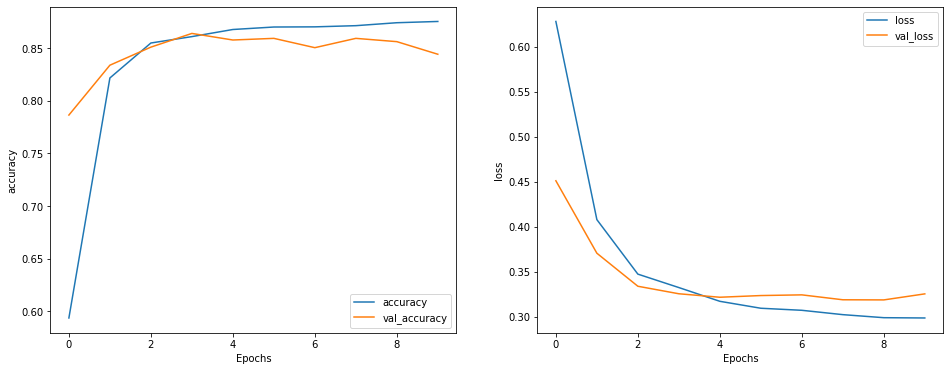

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [27]:
model_stacked.save('text-classification/stacked')

INFO:tensorflow:Assets written to: text-classification/stacked/assets


INFO:tensorflow:Assets written to: text-classification/stacked/assets


In [24]:
model.save('text-classification/one-layer')

INFO:tensorflow:Assets written to: text-classification/one-layer/assets


INFO:tensorflow:Assets written to: text-classification/one-layer/assets
